In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot exetent/area from observations and models (past and future)
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [2]:
# Plotting Info
runType = 'forecast'
variables = ['sic'] #, 'hi'
metric1 = 'extent'

In [3]:
# Initialization times to plot
cd = datetime.datetime.now()
cd = datetime.datetime(cd.year, cd.month, cd.day) # Assumes hours 00, min 00
SD = cd - datetime.timedelta(days=90)
ED = cd + datetime.timedelta(days=365)

In [4]:
# Info about models runs
# icePredicted = {'gfdlsipn':True, 'piomas':True, 'yopp':True, 'bom':False, 'cma':True, 'ecmwf':True, 
#               'hcmr':False, 'isaccnr':False, 'jma':False, 'metreofr':True, 'ukmo':True, 'eccc':False, 
#               'kma':True, 'ncep':True, 'ukmetofficesipn':True, 'ecmwfsipn':True}
# biasCorrected = 

In [5]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()

In [6]:
# Load obs
import timeit
start_time = timeit.default_timer()
ds_obs = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'/*.nc', concat_dim='time', autoclose=True)#,
print(timeit.default_timer() - start_time)

359.32155907002743


In [7]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

In [8]:
cdate = datetime.datetime.now()


# Plot Raw extents and only models that predict sea ice

Sea of Okhotsk
gfdlsipn
0.5188901571091264  seconds.
piomas
yopp
3.9506670760456473  seconds.
ecmwf
0.4846092719817534  seconds.
metreofr
0.2953200440388173  seconds.
ukmo
2.32838369498495  seconds.
kma
1.9445275149773806  seconds.
ncep
1.7342488910071552  seconds.
ukmetofficesipn
23.73649344604928  seconds.
ecmwfsipn
0.04270824801642448  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Bering
gfdlsipn
1.0836132609983906  seconds.
piomas
yopp
4.24702912196517  seconds.
ecmwf
0.448215747019276  seconds.
metreofr
0.3505533110583201  seconds.
ukmo
1.5548852509818971  seconds.
kma
1.3444653360638767  seconds.
ncep
1.8093252578983083  seconds.
ukmetofficesipn
16.613297051982954  seconds.
ecmwfsipn
0.03638583596330136  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Hudson Bay
gfdlsipn
0.9387366459704936  seconds.
piomas
yopp
4.440516603062861  seconds.
ecmwf
0.6652791569940746  seconds.
metreofr
0.3145267160143703  seconds.
ukmo
1.4327553869225085  seconds.
kma
1.3983578640036285  seconds.
ncep
1.7561545389471576  seconds.
ukmetofficesipn
18.468308867071755  seconds.
ecmwfsipn
0.04801979300100356  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


St John
gfdlsipn
1.005663093063049  seconds.
piomas
yopp
3.629662538995035  seconds.
ecmwf
0.3657974189845845  seconds.
metreofr
0.190745091997087  seconds.
ukmo
2.5864621410146356  seconds.
kma
1.5270646690623835  seconds.
ncep
0.7626802279846743  seconds.
ukmetofficesipn
14.07212620403152  seconds.
ecmwfsipn
0.1338102340232581  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Baffin Bay
gfdlsipn
1.041054219007492  seconds.
piomas
yopp
3.4030142230913043  seconds.
ecmwf
0.40336393006145954  seconds.
metreofr
0.3866637530736625  seconds.
ukmo
1.931584630976431  seconds.
kma
2.2321392060257494  seconds.
ncep
1.798822219017893  seconds.
ukmetofficesipn
15.694233307964168  seconds.
ecmwfsipn
0.04346153396181762  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


East Greenland Sea
gfdlsipn
1.2174922139383852  seconds.
piomas
yopp
4.1015011760173365  seconds.
ecmwf
0.4899074850836769  seconds.
metreofr
0.24436245299875736  seconds.
ukmo
2.0557039469713345  seconds.
kma
1.6612375320401043  seconds.
ncep
1.9848219780251384  seconds.
ukmetofficesipn
16.650585880037397  seconds.
ecmwfsipn
0.04028146399650723  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Barents Sea
gfdlsipn
0.9328151559457183  seconds.
piomas
yopp
4.380376118002459  seconds.
ecmwf
0.5920196280349046  seconds.
metreofr
0.24372225208207965  seconds.
ukmo
2.125636684941128  seconds.
kma
2.128200525068678  seconds.
ncep
1.9594423910602927  seconds.
ukmetofficesipn
18.617337843053974  seconds.
ecmwfsipn
0.04205803794320673  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Kara Sea
gfdlsipn
0.9046166050247848  seconds.
piomas
yopp
3.7773898009909317  seconds.
ecmwf
0.4356178720481694  seconds.
metreofr
0.2013385200407356  seconds.
ukmo
1.4995444710366428  seconds.
kma
1.6974733689567074  seconds.
ncep
2.290404931991361  seconds.
ukmetofficesipn
21.317039872985333  seconds.
ecmwfsipn
0.036882821936160326  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Laptev Sea
gfdlsipn
0.9048831160180271  seconds.
piomas
yopp
4.384073858964257  seconds.
ecmwf
0.5563818279188126  seconds.
metreofr
0.2068435150431469  seconds.
ukmo
1.708692211075686  seconds.
kma
1.916648579062894  seconds.
ncep
1.746703619020991  seconds.
ukmetofficesipn
24.218152868910693  seconds.
ecmwfsipn
0.040091139962896705  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


East Siberian Sea
gfdlsipn
0.4199924840359017  seconds.
piomas
yopp
1.8680061539635062  seconds.
ecmwf
0.6497935230145231  seconds.
metreofr
0.3842886519851163  seconds.
ukmo
2.202723833033815  seconds.
kma
3.7088332480052486  seconds.
ncep
1.4791429280303419  seconds.
ukmetofficesipn
31.011361976037733  seconds.
ecmwfsipn
0.05367011309135705  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Chukchi Sea
gfdlsipn
0.4527151150396094  seconds.
piomas
yopp
1.7249484889907762  seconds.
ecmwf
0.21819368505384773  seconds.
metreofr
0.11972308706026524  seconds.
ukmo
0.8335885109845549  seconds.
kma
0.8432570330332965  seconds.
ncep
1.1988467540359125  seconds.
ukmetofficesipn
28.522987094940618  seconds.
ecmwfsipn
0.11129650298971683  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Beaufort Sea
gfdlsipn
0.4273663479834795  seconds.
piomas
yopp
1.703434603055939  seconds.
ecmwf
0.21476672193966806  seconds.
metreofr
0.12984841200523078  seconds.
ukmo
0.8271034439094365  seconds.
kma
0.8053953680209816  seconds.
ncep
0.829392584040761  seconds.
ukmetofficesipn
27.092902656062506  seconds.
ecmwfsipn
0.11110424809157848  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Canadian Islands
gfdlsipn
1.1143545819213614  seconds.
piomas
yopp
3.3284665410174057  seconds.
ecmwf
0.2116616991115734  seconds.
metreofr
0.11359162791632116  seconds.
ukmo
0.7468969849869609  seconds.
kma
0.8187184020644054  seconds.
ncep
0.8274366720579565  seconds.
ukmetofficesipn
19.89863409602549  seconds.
ecmwfsipn
0.08059338899329305  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


Central Arctic
gfdlsipn
1.1988544659689069  seconds.
piomas
yopp
3.6972086429595947  seconds.
ecmwf
0.4324870379641652  seconds.
metreofr
0.19117522798478603  seconds.
ukmo
1.451374945929274  seconds.
kma
1.7686458360403776  seconds.
ncep
0.8783742930972949  seconds.
ukmetofficesipn
13.785963297937997  seconds.
ecmwfsipn
0.08895377407316118  seconds.
usnavysipn
usnavyncep
rasmesrl
Plotting observations


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


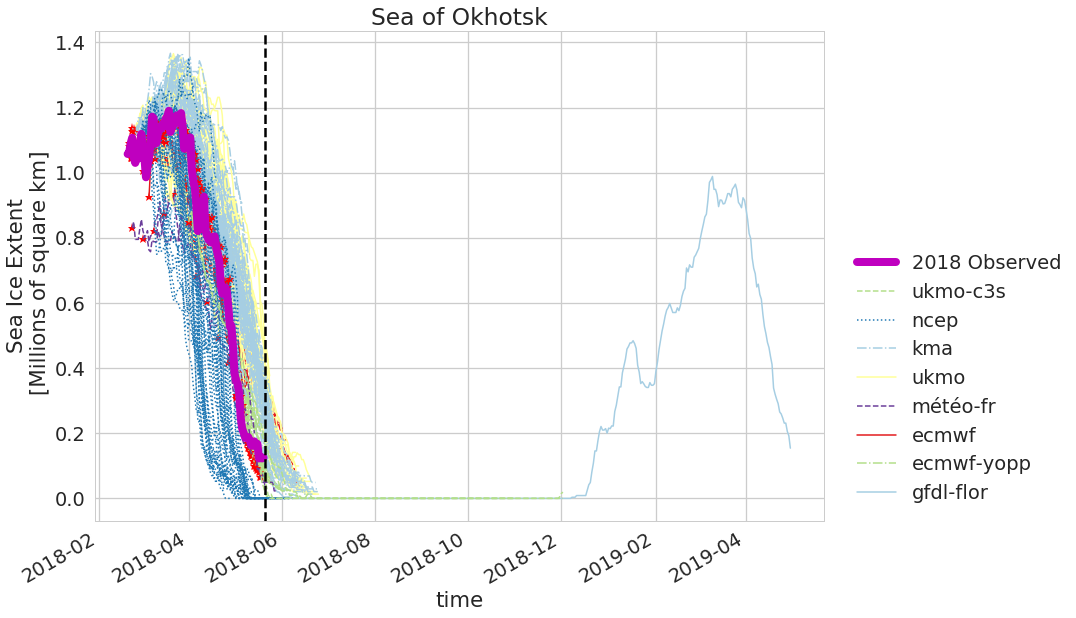

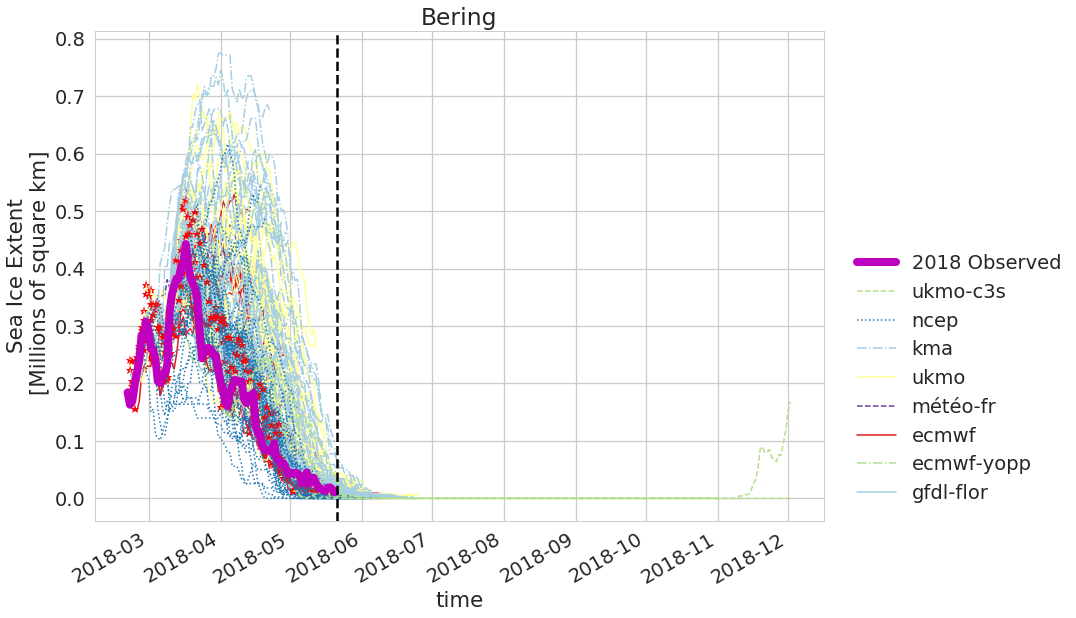

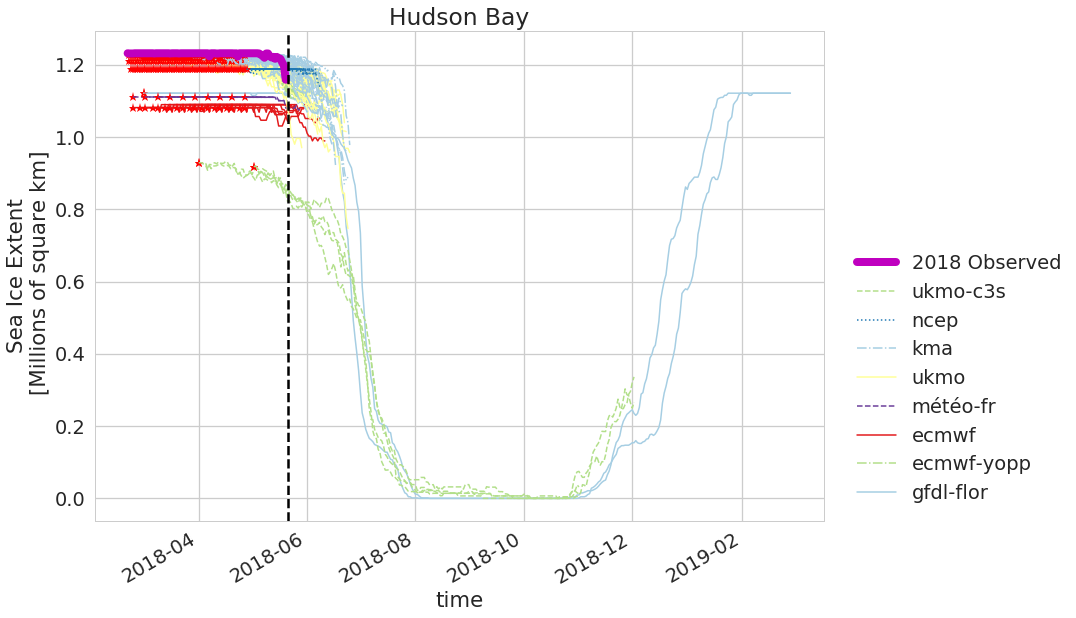

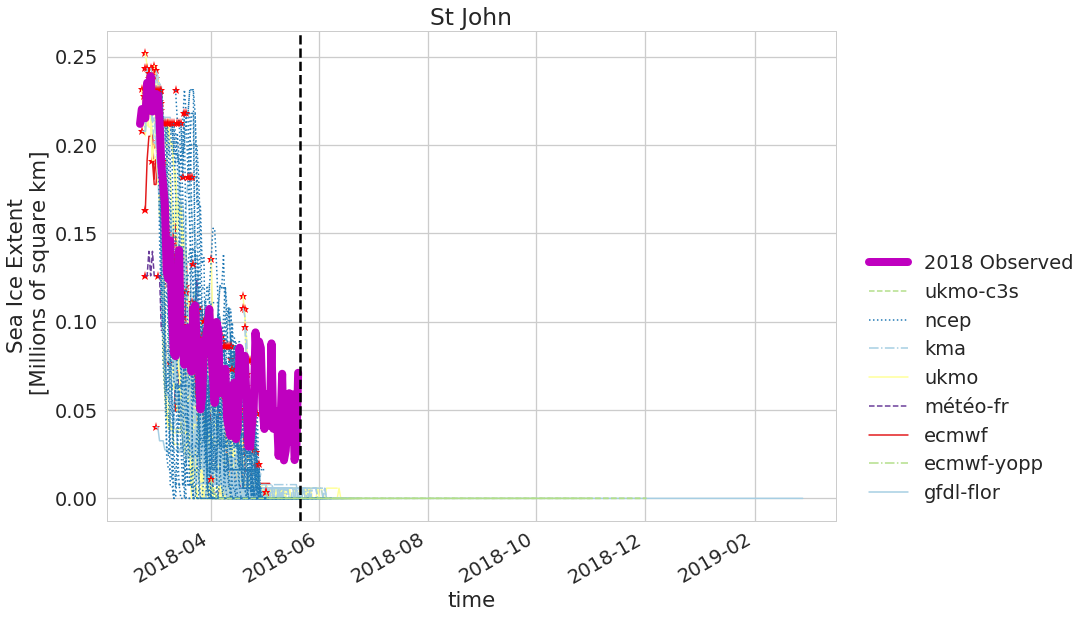

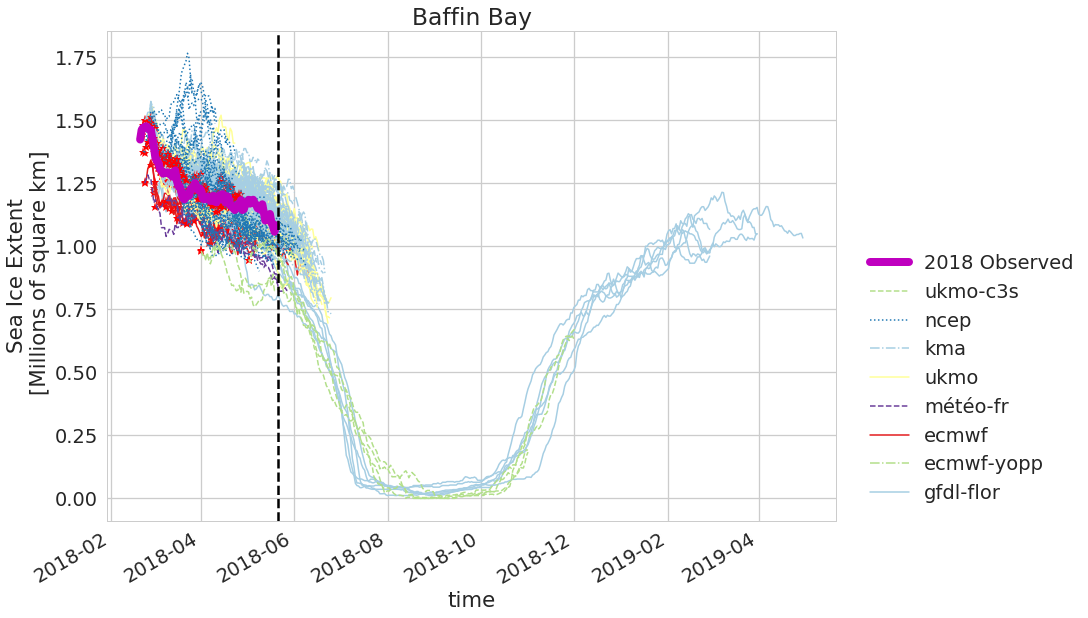

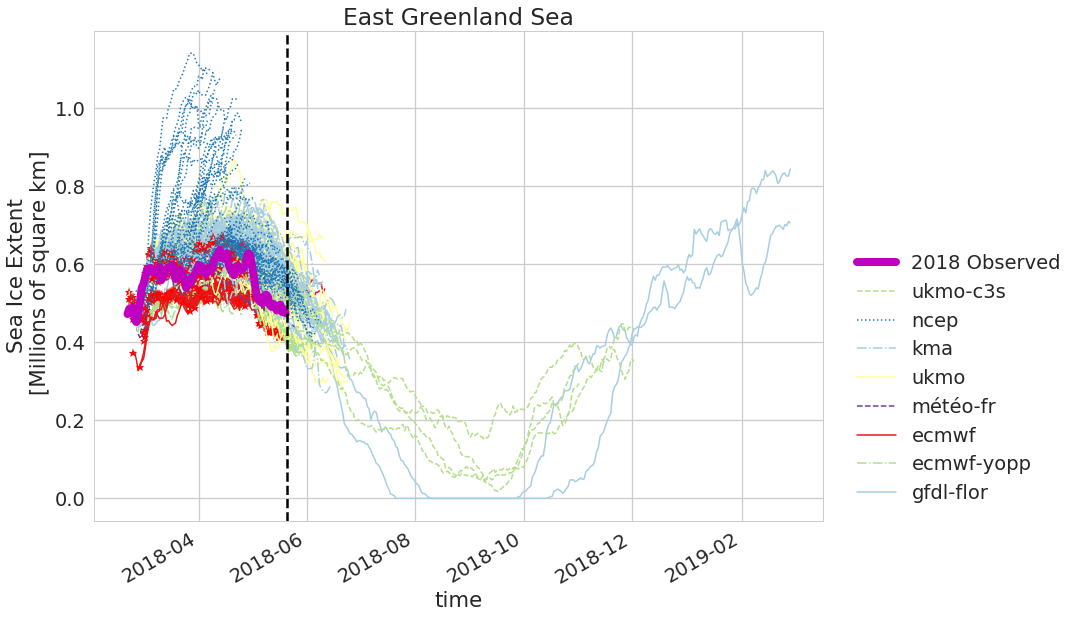

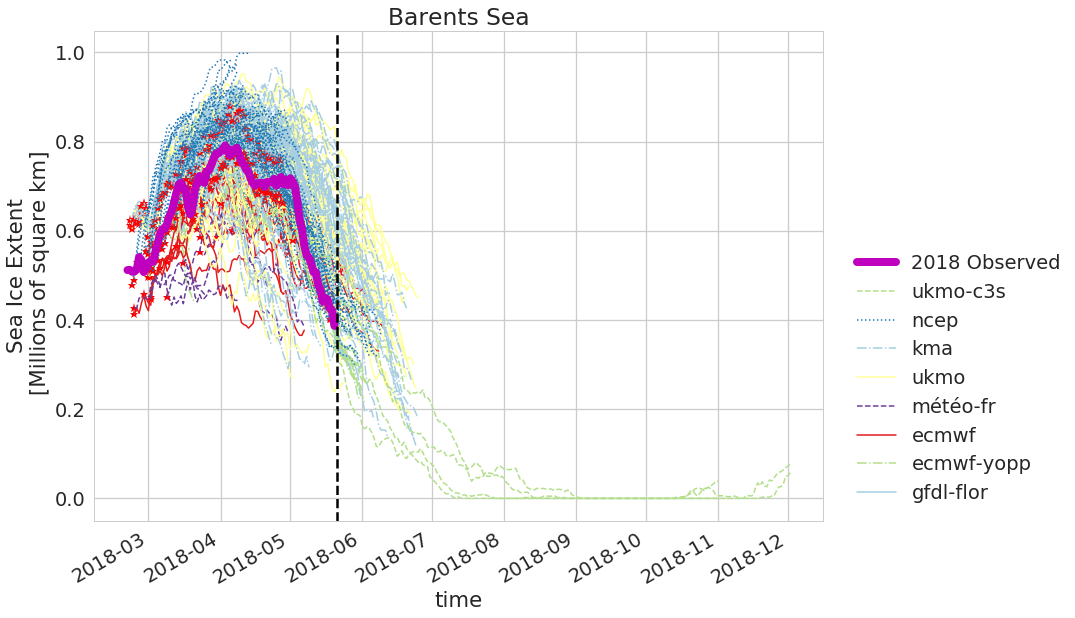

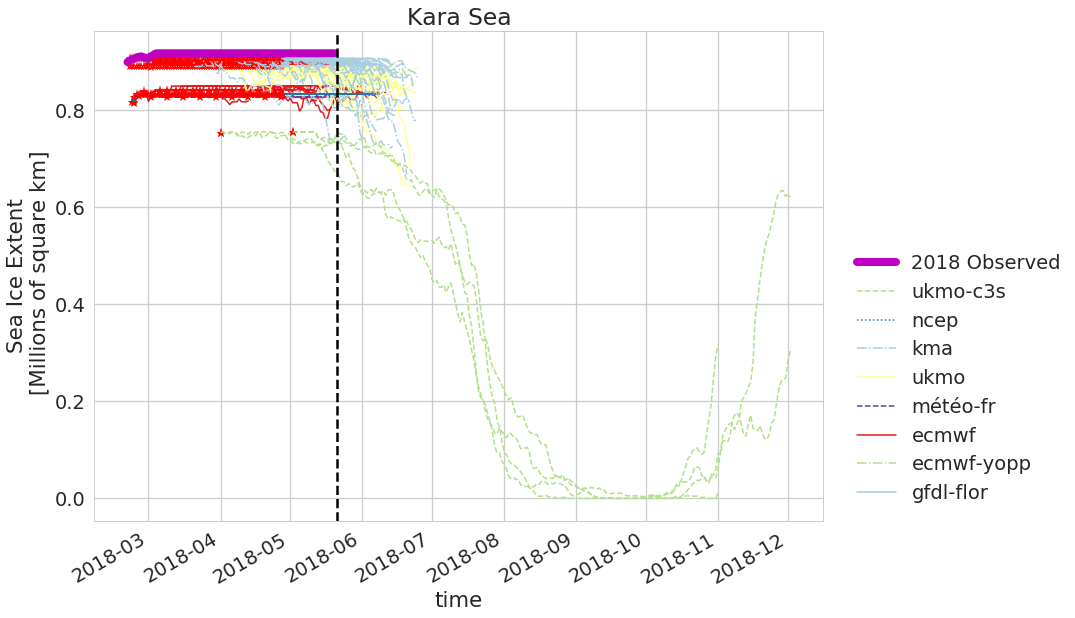

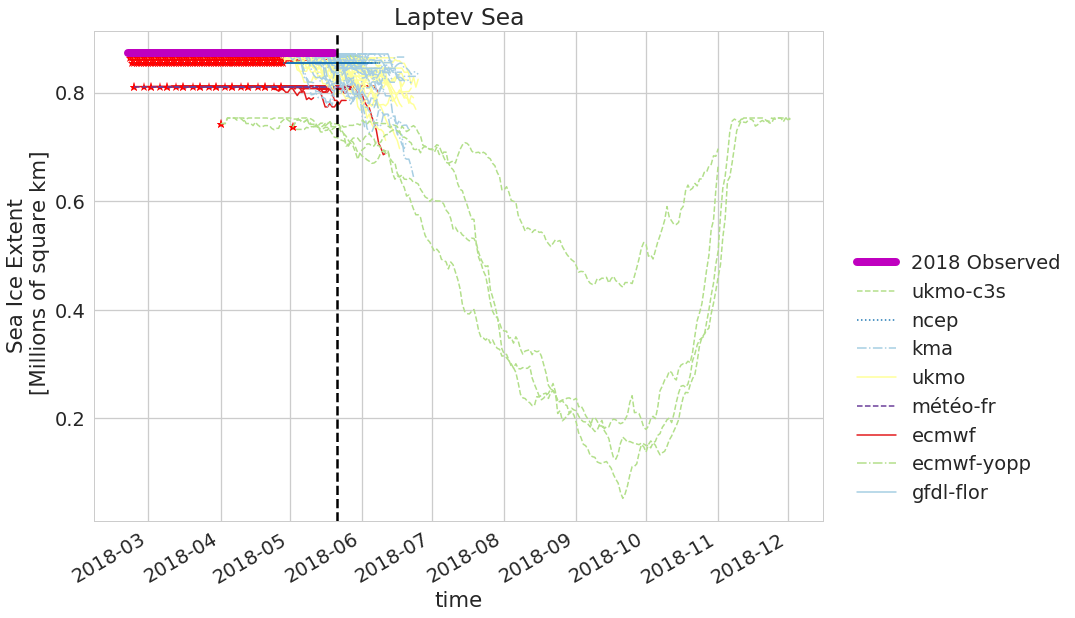

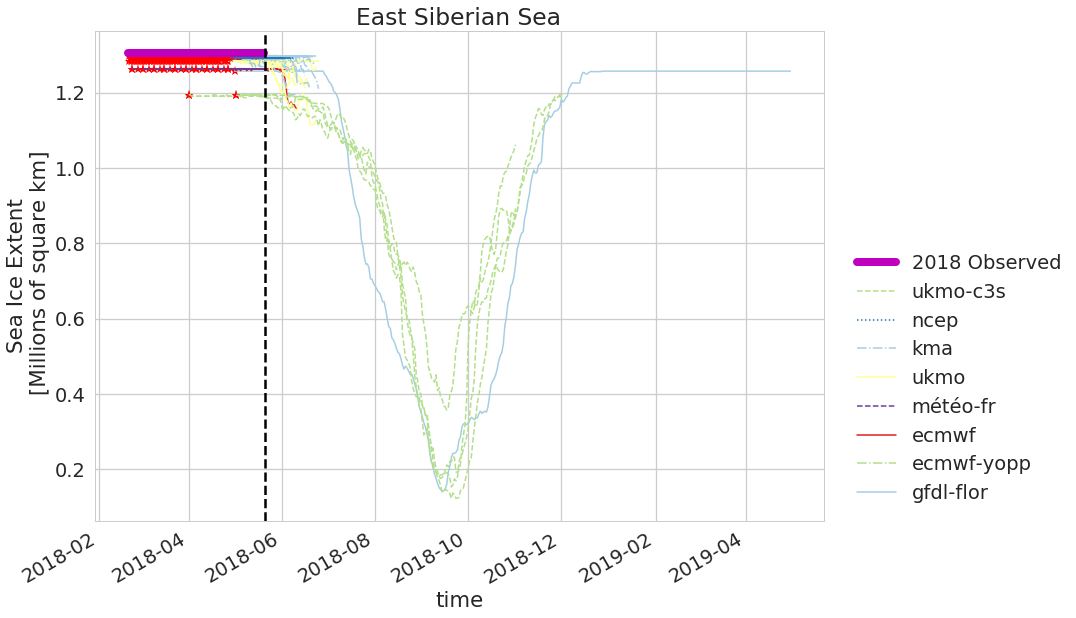

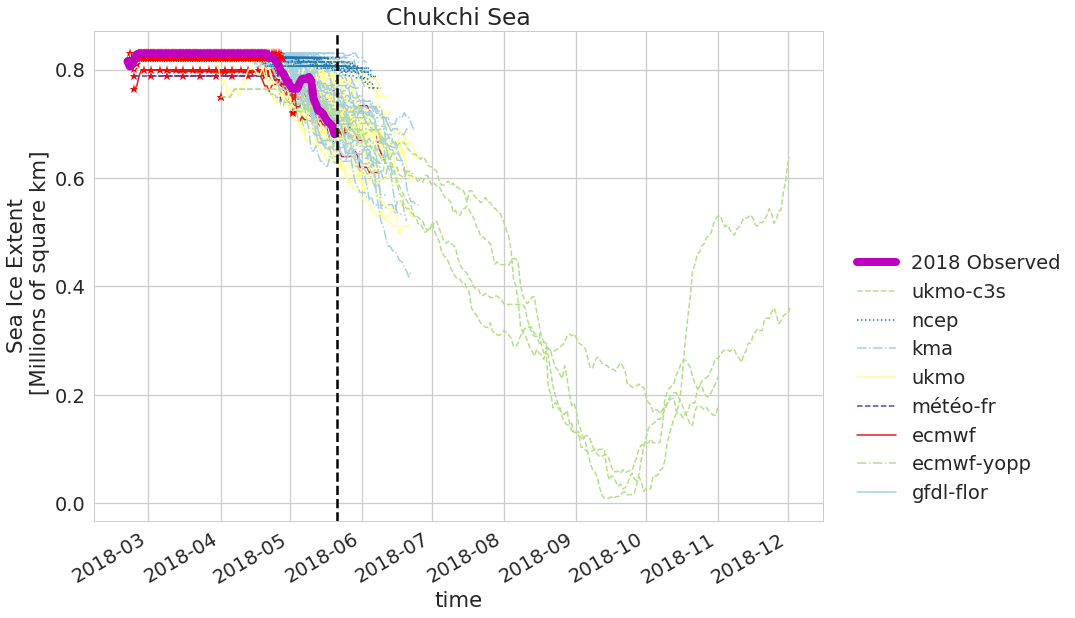

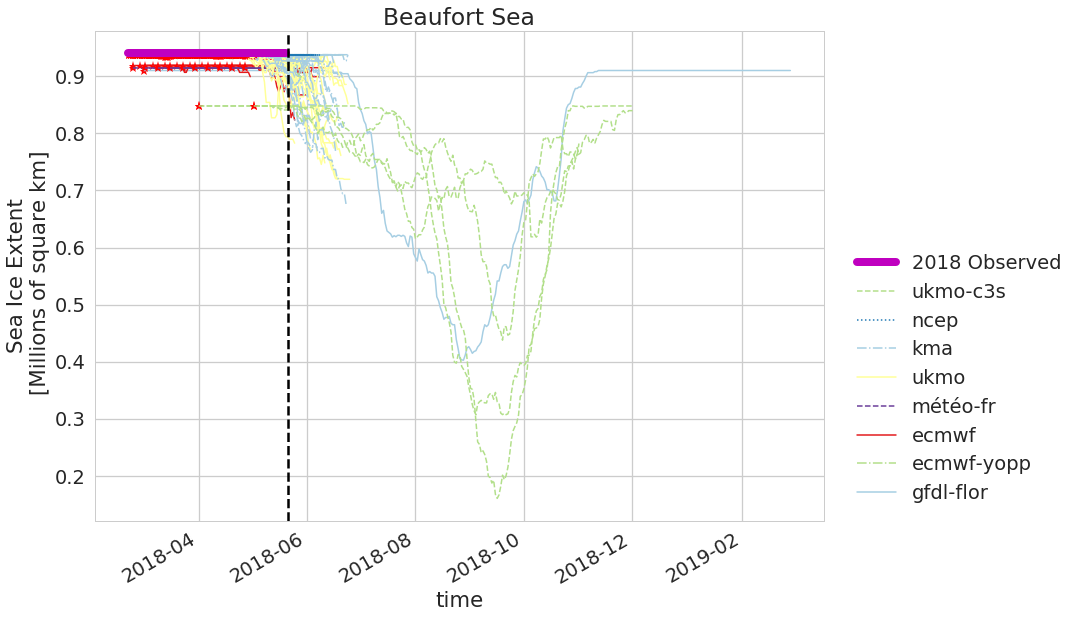

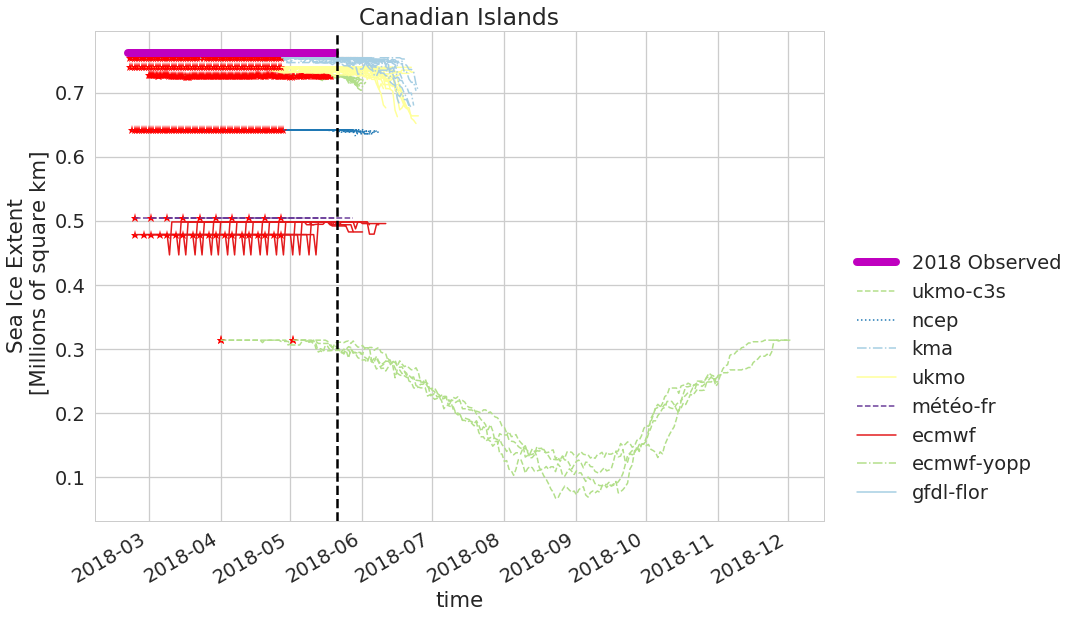

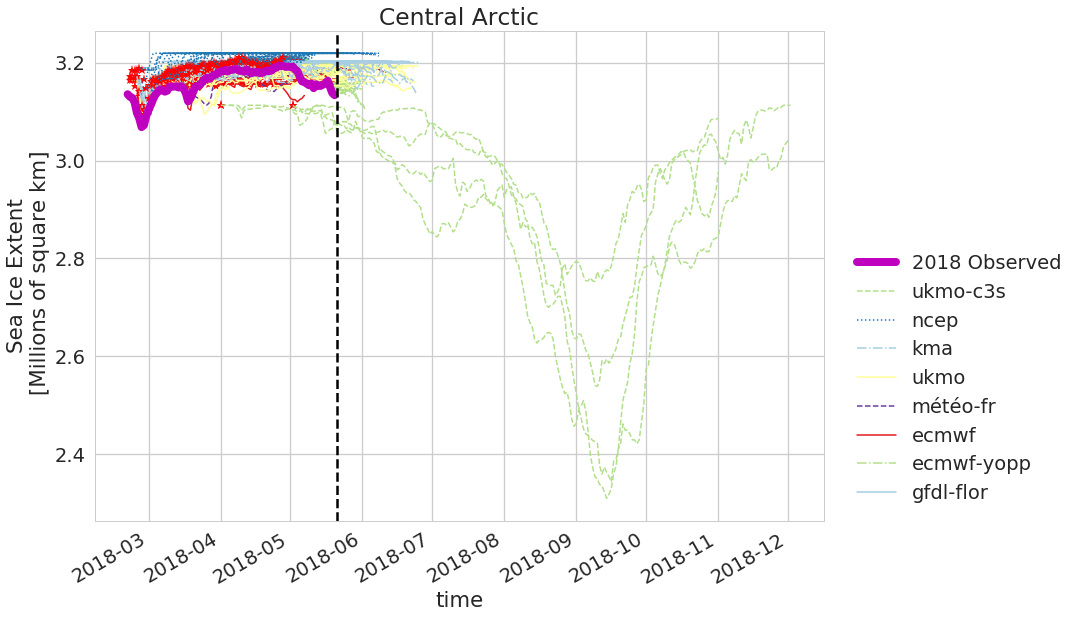

In [9]:
# cmap_c = itertools.cycle(sns.color_palette("Paired", len(E.model.keys()) ))
# linecycler = itertools.cycle(["-","--","-.",":","--"])
for cvar in variables:
    
    fig_dir = os.path.join(E.fig_dir, 'model', 'all_model', cvar, "regional_timeseries")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # For each region
    for cR in ds_region.ocean_regions.values:    
        cR_name = ds_region.region_names.sel(nregions=cR).item(0)
        print(cR_name)

        # New Plot
        f = plt.figure(figsize=(15,10))
        ax1 = plt.subplot(1, 1, 1) # Observations

        for (i, cmod) in enumerate(E.model.keys()):
#         for (i, cmod) in enumerate(['usnavyncep','usnavysipn']):

            if not E.icePredicted[cmod]:
                continue
            print(cmod)
            # Load in Model
            model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc_agg'], '*.nc')

            # Check we have files 
            files = glob.glob(model_forecast)
            if not files:
                #print("Skipping model", cmod, "no forecast files found.")
                continue # Skip this model
            ds_model = xr.open_mfdataset(model_forecast, concat_dim='init_time')

            # Get Extent
            ds_model = ds_model.Extent

            # Select init of interest
            ds_model = ds_model.where(ds_model.init_time>=np.datetime64(SD), drop=True)
            
#             # Take mean of ensemble
#             ds_model = ds_model.mean(dim='ensemble')

            # Select region
            ds_model = ds_model.sel(nregions=cR)

            # Get model plotting specs
            cc = E.model_color[cmod]
            cl = E.model_linestyle[cmod]

            # Plot Model
            if i == 1: # Control only one initiailzation label in legend
                no_init_label = False
            else:
                no_init_label = True
            import timeit
            start_time = timeit.default_timer()
            
            esio.plot_reforecast(ds=ds_model, axin=ax1, 
                                 labelin=E.model[cmod]['model_label'],
                                 color=cc, marker=None,
                                 linestyle=cl,
                                 no_init_label=no_init_label)
            print( (timeit.default_timer() - start_time), ' seconds.' )

            # Memeory clean up
            ds_model = None

        # Plot observations
        print('Plotting observations')
        ds_obs_reg = ds_obs.sic.where(ds_obs.time>=np.datetime64(SD), drop=True)
        ds_obs_reg = ds_obs_reg.where(ds_region.mask==cR)
        ds_obs_reg = ((ds_obs_reg >= 0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
        ds_obs_reg.plot(ax=ax1, label=str(cdate.year)+' Observed', color='m', linewidth=8)
        ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
        cxlims = ax1.get_xlim()
        

    #     # 1980-2010 Historical Interquartile Range
    #     plt.fill_between(ds_per_mean.time.values, ds_per_mean + ds_per_std, 
    #                  ds_per_mean - ds_per_std, alpha=0.35, label='1980-2010\nInterquartile Range', color='m')
        ax1.set_xlim(cxlims) # fix x limits
        cylims = ax1.get_ylim()

        # Plot current date line
        ax1.plot([cd, cd], [cylims[0], cylims[1]], color='k', linestyle='--')
        
        ax1.set_title(cR_name)

        # Add legend (static)
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles[::-1], labels[::-1], loc='lower right',bbox_to_anchor=(1.35, 0))

        f.autofmt_xdate()
        ax1.set_ylim(cylims)
        plt.subplots_adjust(right=.8)

        # Save to file
        base_name_out = 'Region_'+cR_name.replace(" ", "_")+'_'+metric1+'_'+runType+'_raw_predicted'
        f_out = os.path.join(fig_dir, base_name_out+'.png')
        f.savefig(f_out,bbox_inches='tight',dpi=200)
        mpld3.save_html(f, os.path.join(fig_dir, base_name_out+'.html'))

        # Mem clean up
        ds_model = None
        ds_obs_reg = None
        f = None